In [1]:
# package imports

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import optuna

In [2]:
df = pd.read_csv('./telco-customer-data.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.iloc[1,:]

customerID            5575-GNVDE
gender                      Male
SeniorCitizen                  0
Partner                       No
Dependents                    No
tenure                        34
PhoneService                 Yes
MultipleLines                 No
InternetService              DSL
OnlineSecurity               Yes
OnlineBackup                  No
DeviceProtection             Yes
TechSupport                   No
StreamingTV                   No
StreamingMovies               No
Contract                One year
PaperlessBilling              No
PaymentMethod       Mailed check
MonthlyCharges             56.95
TotalCharges              1889.5
Churn                         No
Name: 1, dtype: object

In [5]:
# map column names to more readable names
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [6]:
df.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
# Check for uninformative columns
df.nunique().T

customerid          7043
gender                 2
seniorcitizen          2
partner                2
dependents             2
tenure                73
phoneservice           2
multiplelines          3
internetservice        3
onlinesecurity         3
onlinebackup           3
deviceprotection       3
techsupport            3
streamingtv            3
streamingmovies        3
contract               3
paperlessbilling       2
paymentmethod          4
monthlycharges      1585
totalcharges        6531
churn                  2
dtype: int64

In [8]:
low_cardinality_cols = ['gender', 'seniorcitizen', 'partner', 
                        'dependents', 'phoneservice', 'multiplelines', 
                        'internetservice', 'onlinesecurity', 'onlinebackup', 
                        'deviceprotection', 'techsupport', 'streamingtv', 
                        'streamingmovies', 'contract', 'paperlessbilling',
                        'paymentmethod', 'churn']

high_cardinality_cols = df.columns.difference(low_cardinality_cols)

In [9]:
low_card_dict = {}
for col in low_cardinality_cols:
    low_card_dict[str(col)] = {'unique_vals':[df[col].unique()], 'dtype': df[col].dtype}
    
val_df = pd.DataFrame(low_card_dict).T
val_df

,unique_vals,dtype
gender,"[[Female, Male]]",object
seniorcitizen,"[[0, 1]]",int64
partner,"[[Yes, No]]",object
dependents,"[[No, Yes]]",object
phoneservice,"[[No, Yes]]",object
multiplelines,"[[No phone service, No, Yes]]",object
internetservice,"[[DSL, Fiber optic, No]]",object
onlinesecurity,"[[No, Yes, No internet service]]",object
onlinebackup,"[[Yes, No, No internet service]]",object
deviceprotection,"[[No, Yes, No internet service]]",object


Seems like there are no trivial features in the dataset where there is a single value for all samples.
Of the low cardinality features, there appear to be no features where a the category labels are not logical. Next we look at the distribution over each feature to ensure there are no features where a single category is not trivially under-represented. We also check the data type of the features and as to be expected with categorical features they are object (str) types.

We can expand this more generally to see if there are features where the dtype is not what we expect.


In [10]:
# Check to see that high cardinality columns are all ints or floats for memory optimization.
df[high_cardinality_cols].dtypes

customerid         object
monthlycharges    float64
tenure              int64
totalcharges       object
dtype: object

Here the customer id is understandably a string as it is a unique identifier for each customer. The other features should be monthlycharges (float), as it is a dollar amount, tenure (int), as it is the number of months the customer has been with the company, and totalcharges (int), as it is the number of charges that have occured on the account.  
Here we have an issue with totalcharges as it has been parsed as a string.


In [11]:
#pd.to_numeric(df['totalcharges'])

In [12]:
len(df.loc[df['totalcharges']==' '])

11

There are 11 customers that have no total charges. This can be explained by looking at their tenure months. These customers are new and have not been charged yet. We can correct this by setting the totalcharges to 0 for these customers.

In [13]:
df.loc[df['totalcharges']==' '].head(11)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [14]:
# Fill the missing values for totalcharges with 0
df['totalcharges'] = df['totalcharges'].replace(' ', 0)
assert(len(df.loc[df['totalcharges']==' '])==0)
# Convert the totalcharges column to numeric
df['totalcharges'] = pd.to_numeric(df['totalcharges'])

In [15]:
# Handle spaces in feature values for later plotting
blank_space_cols = ['phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract',
       'paymentmethod']

def fix_spaces(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    """_summary_

    Args:
        df (pd.DataFrame): _description_
        cols (list): _description_

    Returns:
        pd.DataFrame: _description_
    """
    return df.replace(' ', '_', regex=True, inplace=True)

fix_spaces(df, blank_space_cols)

In [16]:
df.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No_phone_service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No_phone_service,DSL,Yes,...,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber_optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,Yes


In [17]:
# Separate the target variable from the features
df['churn'] = df['churn'].replace({'Yes':1, 'No':0})
y = df['churn']
X = df.drop('churn', axis=1).copy()

#### One Hot Encoding

OHE is needed for XGBoost as the algorithm only supports numerical features. We can do this by using ColumnTransformer from sklearn or get_dummies from Pandas.

In [18]:
df.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [19]:
cat_cols = ['gender', 'partner', 'dependents',
        'phoneservice', 'multiplelines', 'internetservice',
        'onlinesecurity', 'onlinebackup', 'deviceprotection',
        'techsupport', 'streamingtv', 'streamingmovies', 
        'contract', 'paperlessbilling', 'paymentmethod']

In [20]:
from sklearn.compose import ColumnTransformer
# ct = ColumnTransformer()




In [21]:

X_pandas_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=False)
X_pandas_encoded.drop('customerid', axis=1, inplace=True)
X_pandas_encoded.head(10)


,seniorcitizen,tenure,monthlycharges,totalcharges,gender_Female,gender_Male,partner_No,partner_Yes,dependents_No,dependents_Yes,...,streamingmovies_Yes,contract_Month-to-month,contract_One_year,contract_Two_year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank_transfer_(automatic),paymentmethod_Credit_card_(automatic),paymentmethod_Electronic_check,paymentmethod_Mailed_check
0,0,1,29.85,29.85,1,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,1,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,1,1,0,1,0,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
5,0,8,99.65,820.50,1,0,1,0,1,0,...,1,1,0,0,0,1,0,0,1,0
6,0,22,89.10,1949.40,0,1,1,0,0,1,...,0,1,0,0,0,1,0,1,0,0
7,0,10,29.75,301.90,1,0,1,0,1,0,...,0,1,0,0,1,0,0,0,0,1
8,0,28,104.80,3046.05,1,0,0,1,1,0,...,1,1,0,0,0,1,0,0,1,0
9,0,62,56.15,3487.95,0,1,1,0,0,1,...,0,0,1,0,1,0,1,0,0,0


In [22]:
y.unique() # Verify that the target variable is binary

array([0, 1])

In [23]:
# Check incidence of churn 
sum(y)/len(y) 


0.2653698707936959

Approximately 26.5% of customers in the dataset have churned so we should use stratify=y when splitting the data into train and test sets.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_pandas_encoded, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
print(f"The incidence of churn in the training set is {round(sum(y_train)/len(y_train), 2)}, in the test set it is {round(sum(y_test)/len(y_test),2)}")

The incidence of churn in the training set is 0.27, in the test set it is 0.27


In [26]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                            eval_metric="aucpr",
                            early_stopping_rounds=10,
                            seed=42)
clf_xgb.fit(X_train, 
            y_train, 
            verbose=True, 
            eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.64103
[1]	validation_0-aucpr:0.64175
[2]	validation_0-aucpr:0.64108
[3]	validation_0-aucpr:0.64293
[4]	validation_0-aucpr:0.64225
[5]	validation_0-aucpr:0.64093
[6]	validation_0-aucpr:0.63600
[7]	validation_0-aucpr:0.63227
[8]	validation_0-aucpr:0.63157
[9]	validation_0-aucpr:0.63282
[10]	validation_0-aucpr:0.63561
[11]	validation_0-aucpr:0.63538
[12]	validation_0-aucpr:0.63495
[13]	validation_0-aucpr:0.63494


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [27]:
clf_xgb.predict(X_test)

array([0, 1, 0, ..., 0, 0, 0])

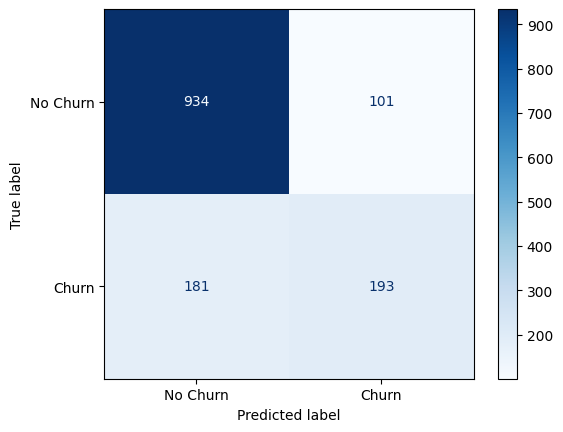

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# predictions = clf_xgb.predict(X_test)
cm = ConfusionMatrixDisplay.from_estimator(clf_xgb,
                                           X_test, 
                                           y_test, 
                                           display_labels=['No Churn','Churn'], cmap='Blues')


As we can see there are 181 false negatives which are cases where the business predicts the customer will not churn and they do churn.  In the telecom case this is the most pertinant issue to address as it is possible that intervention may have prevented churn. 

To improve performance we should attempt to deal with the class imbalance issue. 

### Optimization of XGBoost Parameters Using Cross Validation

In [29]:
param_grid = {'max_depth': [3, 4, 5],
              'learning_rate': [0.1, 0.01, 0.05],
              'gamma': [0, 0.25, 1.0],
              'reg_lambda': [0, 1.0, 10.0],
              'scale_pos_weight': [1, 3, 5]}

In [30]:
# optimization
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42,
                                early_stopping_rounds=10,
                                eval_metric="aucpr",),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=0,
    n_jobs=-1, 
    cv=3
)

In [31]:
# Fit the grid search model
optimal_params.fit(X_train, 
                   y_train, 
                   eval_set=[(X_test, y_test)],
                   verbose=False)
print(optimal_params.best_params_)

{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 10.0, 'scale_pos_weight': 3}


#### Building The Final Model


In [32]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                            gamma=0, 
                            learning_rate=0.1, 
                            max_depth=5, 
                            reg_lambda= 10.0, 
                            scale_pos_weight= 3,
                            seed=42,
                            early_stopping_rounds=10,
                            eval_metric="aucpr")

clf_xgb.fit(X_train, y_train, verbose=True, eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.58794
[1]	validation_0-aucpr:0.59529
[2]	validation_0-aucpr:0.60290
[3]	validation_0-aucpr:0.60426
[4]	validation_0-aucpr:0.60552
[5]	validation_0-aucpr:0.60396
[6]	validation_0-aucpr:0.60164
[7]	validation_0-aucpr:0.61179
[8]	validation_0-aucpr:0.61221
[9]	validation_0-aucpr:0.62655
[10]	validation_0-aucpr:0.63420
[11]	validation_0-aucpr:0.63277
[12]	validation_0-aucpr:0.63527
[13]	validation_0-aucpr:0.63632
[14]	validation_0-aucpr:0.63613
[15]	validation_0-aucpr:0.63668
[16]	validation_0-aucpr:0.63806
[17]	validation_0-aucpr:0.63780
[18]	validation_0-aucpr:0.63964
[19]	validation_0-aucpr:0.63681
[20]	validation_0-aucpr:0.64066
[21]	validation_0-aucpr:0.64210
[22]	validation_0-aucpr:0.64245
[23]	validation_0-aucpr:0.64214
[24]	validation_0-aucpr:0.64288
[25]	validation_0-aucpr:0.64157
[26]	validation_0-aucpr:0.64173
[27]	validation_0-aucpr:0.64507
[28]	validation_0-aucpr:0.64690
[29]	validation_0-aucpr:0.64552
[30]	validation_0-aucpr:0.64520
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

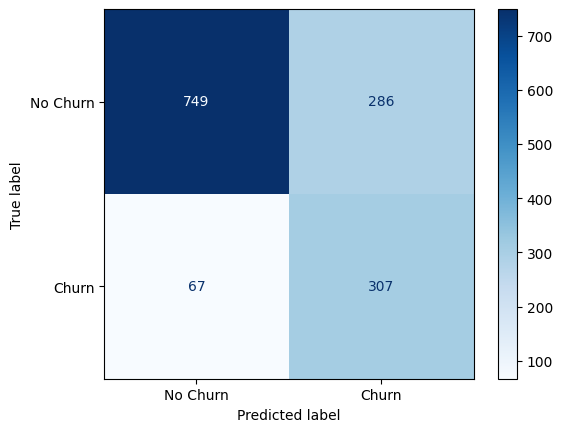

In [33]:
cm = ConfusionMatrixDisplay.from_estimator(clf_xgb,
                                           X_test, 
                                           y_test, 
                                           display_labels=['No Churn','Churn'], cmap='Blues')

Here we see a marginal improvement from 181 to 67 false negatives. This is a 63% reduction in false negatives. This suggests the tuning is quite effective.

#### Drawing The Final Tree


In [34]:
# Get a single tree for printing purposes
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                            gamma=0, 
                            learning_rate=0.1, 
                            max_depth=5, 
                            reg_lambda= 10.0, 
                            scale_pos_weight= 3,
                            seed=42,
                            early_stopping_rounds=10,
                            eval_metric="aucpr",
                            n_estimators=1)

clf_xgb.fit(X_train, y_train, verbose=True, eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.58794


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

weight
{'tenure': 5.0, 'monthlycharges': 3.0, 'totalcharges': 4.0, 'dependents_No': 2.0, 'phoneservice_No': 1.0, 'internetservice_Fiber_optic': 1.0, 'onlinesecurity_No': 1.0, 'techsupport_No': 2.0, 'streamingtv_No': 1.0, 'contract_Month-to-month': 1.0, 'contract_One_year': 1.0, 'paymentmethod_Electronic_check': 1.0, 'paymentmethod_Mailed_check': 1.0}
gain
{'tenure': 40.66895294189453, 'monthlycharges': 45.94150924682617, 'totalcharges': 39.57102584838867, 'dependents_No': 6.754874229431152, 'phoneservice_No': 36.411582946777344, 'internetservice_Fiber_optic': 335.25775146484375, 'onlinesecurity_No': 31.083251953125, 'techsupport_No': 28.9614315032959, 'streamingtv_No': 10.627652168273926, 'contract_Month-to-month': 2006.806884765625, 'contract_One_year': 39.411224365234375, 'paymentmethod_Electronic_check': 16.209457397460938, 'paymentmethod_Mailed_check': 9.013710021972656}
cover
{'tenure': 243.3000030517578, 'monthlycharges': 298.3333435058594, 'totalcharges': 315.625, 'dependents_No

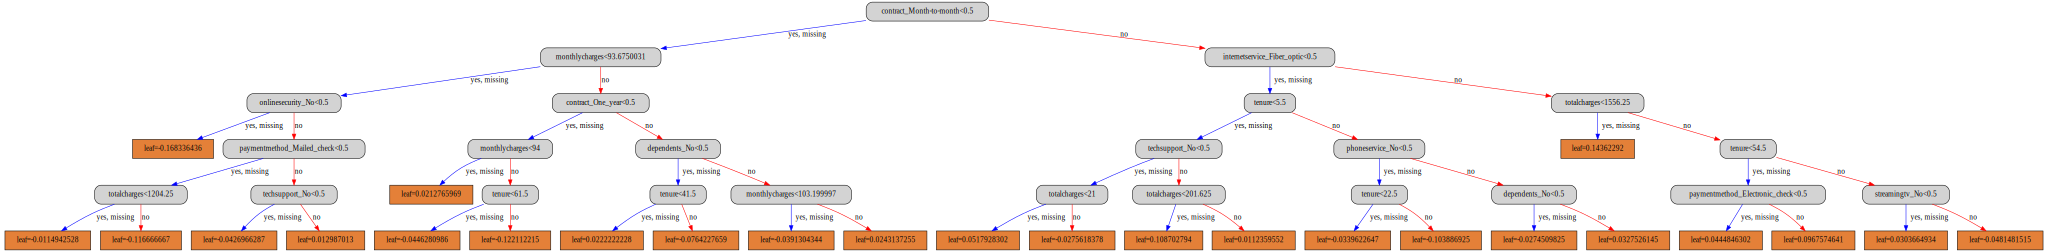

In [35]:
bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print(importance_type)
    print(bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fill_color': '#78cbe'}

leaf_params = {'shape': 'box',
               'style' : 'filled',
               'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb,
                num_trees=0, 
                size="10,10", 
                condition_node_params=node_params, 
                leaf_node_params=leaf_params)
